<a href="https://colab.research.google.com/github/vekoada/tensorflow-course/blob/main/05_transfer_learning_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
#Import helper functions instead of rewriting every time
#!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [32]:
#from helper_functions.py import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir
#Something's wrong with the metadata so not able to import

In [4]:
import urllib.request
import zipfile
url = 'https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip'
filename = '10_food_classes_10_percent.zip'
file = urllib.request.urlretrieve(url, filename)
zip_ref = zipfile.ZipFile(filename)
zip_ref.extractall()
zip_ref.close()

In [5]:
import os
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f"{len(dirnames)} directories and {len(filenames)} images in {dirpath}")

2 directories and 0 images in 10_food_classes_10_percent
10 directories and 0 images in 10_food_classes_10_percent/train
0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry
0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings
0 directories and 75 images in 10_food_classes_10_percent/train/hamburger
0 directories and 75 images in 10_food_classes_10_percent/train/sushi
0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream
0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon
0 directories and 75 images in 10_food_classes_10_percent/train/ramen
0 directories and 75 images in 10_food_classes_10_percent/train/pizza
0 directories and 75 images in 10_food_classes_10_percent/train/steak
0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice
10 directories and 0 images in 10_food_classes_10_percent/test
0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry


In [6]:
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [7]:
import tensorflow as tf

In [8]:
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical',
                                                                            batch_size=32)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical',
                                                                            batch_size=32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
#Create a function to create TensorBoard callbacks for each model
import datetime
def tensorboard(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to {log_dir}")
  return callback

In [14]:
#Create base model (we will use functional API)
base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

#Freeze the base model
base_model.trainable = False

#Create inputs
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')

#If using a model like ResNet50V2 you need to normalize inputs
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

#Pass the inputs to base model
x = base_model(inputs)
print(f'Shape after passing inputs through base model: {x.shape}')

#Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling_layer')(x)
print(f'Shape after global avg pooling 2D: {x.shape}')

#Create output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_later')(x)

#Combine inputs with outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

#Compile
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

#Fit
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data_10_percent,
                        validation_steps=int(0.25*len(test_data_10_percent)),
                        callbacks=[tensorboard(dir_name='transfer_learning',
                                               experiment_name='10_percent_feature_extraction')])

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after global avg pooling 2D: (None, 1280)
Saving TensorBoard log files to transfer_learning/10_percent_feature_extraction/20230914-182130
Epoch 1/5
24/24 [==============================] - 22s 267ms/step - loss: 1.9633 - accuracy: 0.3600 - val_loss: 1.4107 - val_accuracy: 0.6776
Epoch 2/5
24/24 [==============================] - 4s 171ms/step - loss: 1.1912 - accuracy: 0.7467 - val_loss: 0.9205 - val_accuracy: 0.8257
Epoch 3/5
24/24 [==============================] - 5s 171ms/step - loss: 0.8717 - accuracy: 0.8053 - val_loss: 0.7335 - val_accuracy: 0.8470
Epoch 4/5
24/24 [==============================] - 4s 146ms/step - loss: 0.7106 - accuracy: 0.8453 - val_loss: 0.6294 - val_accuracy: 0.8668
Epoch 5/5
24/24 [==============================] - 4s 171ms/step - loss: 0.6228 - accuracy: 0.8653 - val_loss: 0.5556 - val_accuracy: 0.8849


In [15]:
#Evaluate on full test set
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 8s 81ms/step - loss: 0.5895 - accuracy: 0.8580


[0.589476466178894, 0.8579999804496765]

In [17]:
#Check the layers in base model
for layer_n, layer in enumerate(base_model.layers):
  print(layer_n, layer.name, layer)

0 input_3 <keras.src.engine.input_layer.InputLayer object at 0x7f22f648edd0>
1 rescaling_2 <keras.src.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f22f648e8f0>
2 normalization_2 <keras.src.layers.preprocessing.normalization.Normalization object at 0x7f22804b6ce0>
3 stem_conv <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f22805e3a00>
4 stem_bn <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7f22804b5390>
5 stem_activation <keras.src.layers.core.activation.Activation object at 0x7f22804b5780>
6 block1a_project_conv <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f22804b7940>
7 block1a_project_bn <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7f22804b76d0>
8 block1a_project_activation <keras.src.layers.core.activation.Activation object at 0x7f2291b43d00>
9 block2a_expand_conv <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f22804b77c0>
10 block2a_expand_bn <keras.sr

In [18]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, None, None, 3)        0         ['input_3[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, None, None, 3)        0         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [19]:
model_0.summary() #efficientnet is base model with 200+ layers

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_avg_pooling_layer (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_later (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


In [12]:
import matplotlib.pyplot as plt

def plot_loss(history):
  """
  Returns separated loss curves for metrics
  """
  loss=history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  #Loss plot
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

  plt.figure()
  #Accuracy Plot
  plt.plot(epochs, accuracy, label='accuracy')
  plt.plot(epochs, val_acc, label='val_accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend()

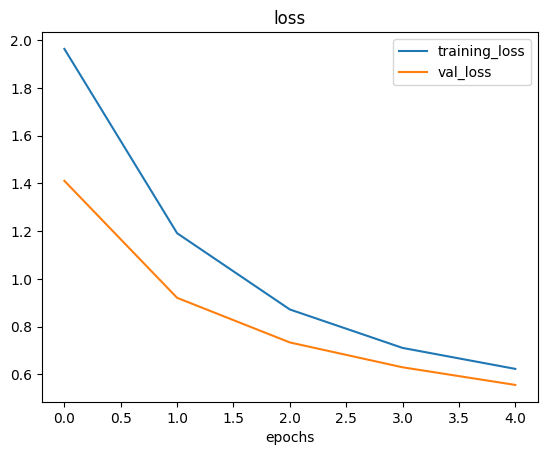

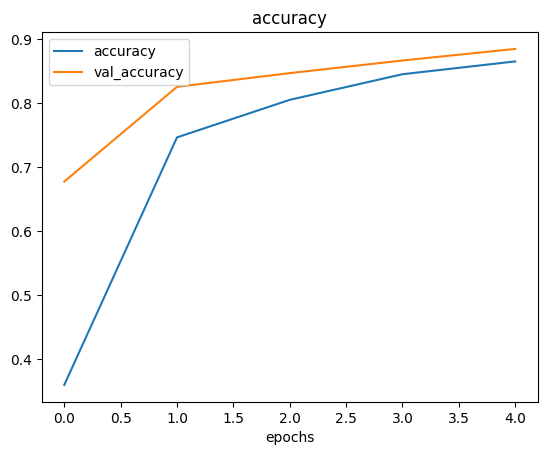

In [21]:
plot_loss(history_0)

### Demonstrating Global Average Pooling 2D
Reshapes from (None, 7, 7, 1280) to (None, 1280)
Let's try (1, 4, 4, 3) and see what happens when we pass it through

In [23]:
#Define input shape
input_shape = (1, 4, 4, 3)

#Create random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor:\n {input_tensor}\n')

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]



In [26]:
#Pass through gap2d layer
pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'2D Global Average Pooled random tensor:\n {pooled_tensor}\n Shape: {pooled_tensor.shape}')

2D Global Average Pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]
 Shape: (1, 3)


In [27]:
#Replicating the functionality
tf.reduce_mean(input_tensor, axis=[1, 2]) #Reduce the tensor to the mean of values along axes 1, 2

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [28]:
#Now passing through Global Max Pooling 2D layer
max_pooled_tensor = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
print(f'2D Global Max Pooled random tensor:\n {max_pooled_tensor}\n Shape: {max_pooled_tensor.shape}')

2D Global Max Pooled random tensor:
 [[0.9058464 1.1603122 1.6994323]]
 Shape: (1, 3)


In [30]:
#Replicating that functionality too
tf.reduce_max(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

### Setting up transfer learning experiments

In [33]:
#Download preprocessed 1% data from Food 101
url = 'https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip'
filename = '10_food_classes_1_percent.zip'
file = urllib.request.urlretrieve(url, filename)
zip_ref = zipfile.ZipFile(filename)
zip_ref.extractall()
zip_ref.close()

In [35]:
for dirpath, dirname, filename in os.walk('10_food_classes_1_percent'):
  print(f'{len(dirname)} directories and {len(filename)} files in {dirpath}')

2 directories and 0 files in 10_food_classes_1_percent
10 directories and 0 files in 10_food_classes_1_percent/train
0 directories and 7 files in 10_food_classes_1_percent/train/chicken_curry
0 directories and 7 files in 10_food_classes_1_percent/train/chicken_wings
0 directories and 7 files in 10_food_classes_1_percent/train/hamburger
0 directories and 7 files in 10_food_classes_1_percent/train/sushi
0 directories and 7 files in 10_food_classes_1_percent/train/ice_cream
0 directories and 7 files in 10_food_classes_1_percent/train/grilled_salmon
0 directories and 7 files in 10_food_classes_1_percent/train/ramen
0 directories and 7 files in 10_food_classes_1_percent/train/pizza
0 directories and 7 files in 10_food_classes_1_percent/train/steak
0 directories and 7 files in 10_food_classes_1_percent/train/fried_rice
10 directories and 0 files in 10_food_classes_1_percent/test
0 directories and 250 files in 10_food_classes_1_percent/test/chicken_curry
0 directories and 250 files in 10_food

In [36]:
train_dir_1_percent = '10_food_classes_1_percent/train'
test_dir = '10_food_classes_1_percent/test'

In [37]:
#Set up data loaders
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode='categorical',
                                                                           image_size=(224, 224),
                                                                           batch_size=32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=(224, 224),
                                                                batch_size=32)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [40]:
#Add data augmentation as a layer in our model - harnesses GPU
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2)#,
    #tf.keras.preprocessing.Rescale(1/255.) Not needed for Efficientnet, but for Resnet
], name='data_augmentation')

(-0.5, 515.5, 300.5, -0.5)

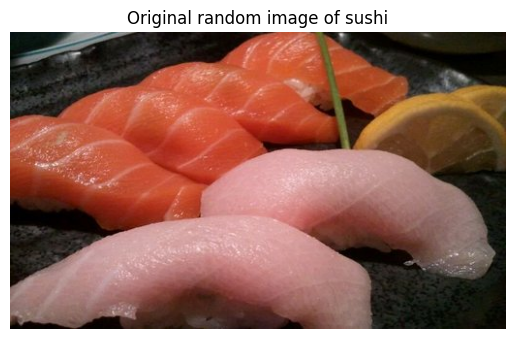

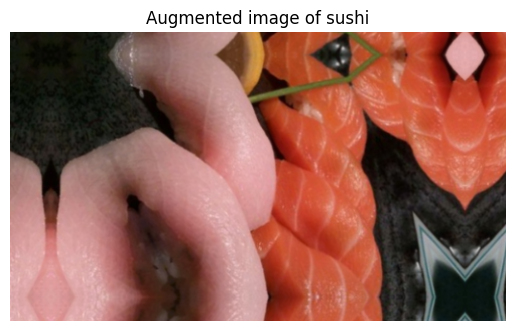

In [49]:
#View a random image and compare with aug. version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = train_dir_1_percent + '/' + target_class
random_img = random.choice(os.listdir(target_dir))
random_img_path = target_dir + '/' + random_img

img = mpimg.imread(random_img_path)
plt.imshow(img)
plt.title(f'Original random image of {target_class}')
plt.axis(False)

augmented_img = data_augmentation(tf.expand_dims(img, axis=0), training=True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f'Augmented image of {target_class}')
plt.axis(False)

In [52]:
#Model 1: now using 1% data and augmentation
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#Create input layer
inputs = tf.keras.layers.Input(shape=input_shape, name='input_layer')

#Add data aug sequential model as layer
x = data_augmentation(inputs) #if layer is whole model, pass param to first set of parens

#Give base model inputs after augmentation (don't train)
x = base_model(x, training=False)

#Pool output features
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x) #if layer is just a layer, pass param in new set of parens

#Dense layer output
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

#Make the model
model_1 = tf.keras.models.Model(inputs, outputs)

model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_1 = model_1.fit(train_data_1_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_1_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        callbacks=[tensorboard(dir_name='transfer_learning',
                                               experiment_name='1_percent_data_aug')])

Saving TensorBoard log files to transfer_learning/1_percent_data_aug/20230914-194409
Epoch 1/5
3/3 [==============================] - 14s 3s/step - loss: 2.3060 - accuracy: 0.0857 - val_loss: 2.2307 - val_accuracy: 0.1727
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.0887 - accuracy: 0.2000 - val_loss: 2.1054 - val_accuracy: 0.2368
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.8729 - accuracy: 0.4286 - val_loss: 1.9961 - val_accuracy: 0.3043
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.7037 - accuracy: 0.5714 - val_loss: 1.9012 - val_accuracy: 0.3651
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.5778 - accuracy: 0.6143 - val_loss: 1.7924 - val_accuracy: 0.4293


In [53]:
model_1.evaluate(test_data)

79/79 [==============================] - 10s 119ms/step - loss: 1.7808 - accuracy: 0.4384


[1.7807831764221191, 0.438400000333786]

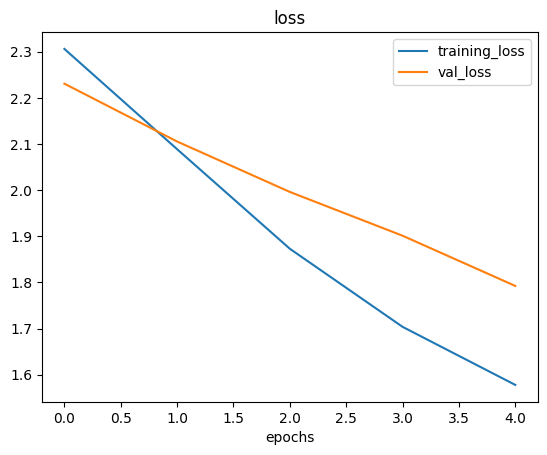

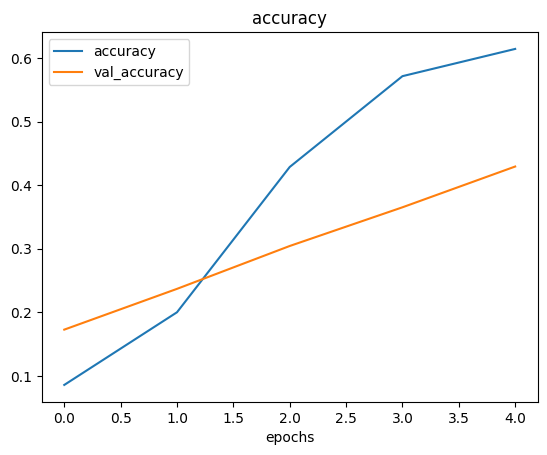

In [55]:
plot_loss(history_1)

### Using 10% data and augmentation

In [1]:
import tensorflow as tf

In [2]:
#Download preprocessed 1% data from Food 101
import urllib.request
import zipfile
url = 'https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip'
filename = '10_food_classes_10_percent.zip'
file = urllib.request.urlretrieve(url, filename)
zip_ref = zipfile.ZipFile(filename)
zip_ref.extractall()
zip_ref.close()

In [3]:
train_dir_10_percent = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [4]:
import os
for dirpath, dirname, filename in os.walk('10_food_classes_10_percent'):
    print(f'{len(dirname)} directories and {len(filename)} files in {dirpath}')

2 directories and 0 files in 10_food_classes_10_percent
10 directories and 0 files in 10_food_classes_10_percent/train
0 directories and 75 files in 10_food_classes_10_percent/train/chicken_wings
0 directories and 75 files in 10_food_classes_10_percent/train/hamburger
0 directories and 75 files in 10_food_classes_10_percent/train/pizza
0 directories and 75 files in 10_food_classes_10_percent/train/ice_cream
0 directories and 75 files in 10_food_classes_10_percent/train/grilled_salmon
0 directories and 75 files in 10_food_classes_10_percent/train/fried_rice
0 directories and 75 files in 10_food_classes_10_percent/train/steak
0 directories and 75 files in 10_food_classes_10_percent/train/chicken_curry
0 directories and 75 files in 10_food_classes_10_percent/train/ramen
0 directories and 75 files in 10_food_classes_10_percent/train/sushi
10 directories and 0 files in 10_food_classes_10_percent/test
0 directories and 250 files in 10_food_classes_10_percent/test/chicken_wings
0 directories 

In [5]:
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode='categorical',
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                      label_mode='categorical',
                                                                      image_size=IMG_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [6]:
#Create model with built-in data augmentation

#Create aug layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomRotation(0.2)
], name='data_augmentation')

#Input shape
input_shape = (224, 224, 3)

#Frozen base model (backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#Inputs, outputs, other layers
inputs = tf.keras.layers.Input(shape=input_shape, name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_2D')(x)
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)
model_2 = tf.keras.Model(inputs, outputs)

#Compile
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

16705208/16705208 [==============================] - 2s 0us/step


In [7]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_2D   (None, 1280)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                             

In [8]:
#This saves the model's weights every epoch to the specified path
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='ten_percent_model_checkpoints_weights/checkpoint.ckpt',
                                                save_weights_only=True,
                                                save_best_only=False,
                                                save_freq='epoch',
                                                verbose=1)

In [13]:
initial_epochs = 5
history_2 = model_2.fit(train_data_10_percent,
                        epochs=initial_epochs,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=0.25*len(test_data),
                        callbacks=[tensorboard(dir_name='transfer_learning',
                                               experiment_name='10_percent_data_aug'),
                                   checkpoint])


Saving TensorBoard log files to transfer_learning/10_percent_data_aug/20230919-023027
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0283 - accuracy: 0.3400
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 35s 819ms/step - loss: 2.0283 - accuracy: 0.3400 - val_loss: 1.4640 - val_accuracy: 0.6875
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3236 - accuracy: 0.6973
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 14s 567ms/step - loss: 1.3236 - accuracy: 0.6973 - val_loss: 1.0189 - val_accuracy: 0.7719
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0049 - accuracy: 0.7747
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 13s 535ms/step - loss: 1.0049 - accuracy: 0.7747 - val_loss: 0.8116 - val_accuracy: 0.8031
Ep

In [16]:
model_2.evaluate(test_data)

79/79 [==============================] - 7s 79ms/step - loss: 0.6254 - accuracy: 0.8400


[0.6254375576972961, 0.8399999737739563]

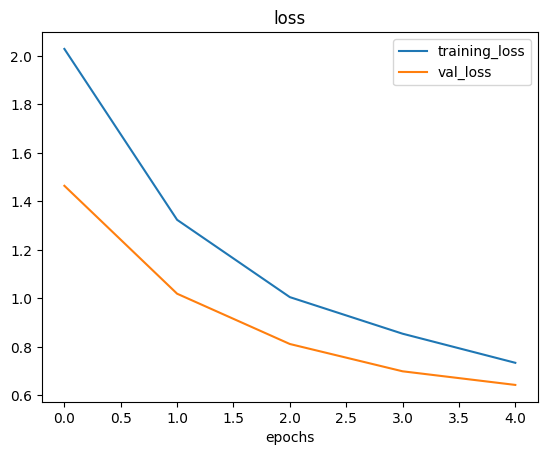

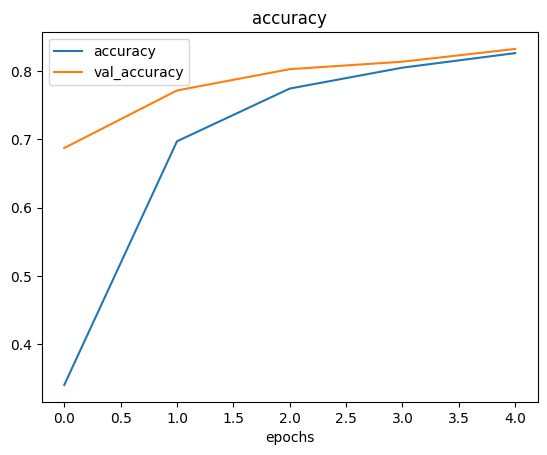

In [14]:
plot_loss(history_2)

In [15]:
#Loading in checkpointed weights
model_2.load_weights('ten_percent_model_checkpoints_weights/checkpoint.ckpt')
#Evaluate with loaded weights to see if it worked
model_2.evaluate(test_data)

79/79 [==============================] - 7s 80ms/step - loss: 0.6254 - accuracy: 0.8400


[0.6254375576972961, 0.8399999737739563]

In [ ]:
#np.isclose() can be used to see if equivalent within some epsilon

# Fine tune with 10% of the data

In [17]:
model_2.layers

In [18]:
for layer in model_2.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 False
global_average_pooling_2D True
output_layer True


In [23]:
#Now looking at the layers within efficientnet
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [19]:
#Check trainable variables
print(len(model_2.layers[2].trainable_variables)) #will give zero because we specified it earlier

0


In [20]:
#Make last 10 layers trainable
base_model.trainable = True

for layer in base_model.layers[:-10]:
  layer.trainable = False

#Recompile every time a change is made
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

#Typically want to lower the learning rate by at least 10x when fine-tuning (rule of thumb)

In [21]:
#Check again which are tunable
for layer_num, layer in enumerate(model_2.layers[2].layers):
  print(layer_num, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [22]:
#Fine tune the model for an additional 5 epochs
fine_tune_epochs = initial_epochs + 5

#Refit the model (same as model_2 -- the difference is that the last 10 layers are trainable)
history_3 = model_2.fit(train_data_10_percent,
                        epochs=fine_tune_epochs,
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        initial_epoch=history_2.epoch[-1], #start training from last epoch's weights
                        callbacks=[tensorboard(dir_name='transfer_learning',
                                               experiment_name='10_percent_fine_tune_last_10')])


Saving TensorBoard log files to transfer_learning/10_percent_fine_tune_last_10/20230919-023226
Epoch 5/10
24/24 [==============================] - 25s 601ms/step - loss: 0.6281 - accuracy: 0.8280 - val_loss: 0.5183 - val_accuracy: 0.8454
Epoch 6/10
24/24 [==============================] - 12s 484ms/step - loss: 0.5207 - accuracy: 0.8400 - val_loss: 0.4583 - val_accuracy: 0.8470
Epoch 7/10
24/24 [==============================] - 11s 446ms/step - loss: 0.4455 - accuracy: 0.8613 - val_loss: 0.4505 - val_accuracy: 0.8503
Epoch 8/10
24/24 [==============================] - 11s 427ms/step - loss: 0.3907 - accuracy: 0.8840 - val_loss: 0.4597 - val_accuracy: 0.8355
Epoch 9/10
24/24 [==============================] - 10s 395ms/step - loss: 0.3524 - accuracy: 0.8987 - val_loss: 0.3984 - val_accuracy: 0.8602
Epoch 10/10
24/24 [==============================] - 11s 449ms/step - loss: 0.3250 - accuracy: 0.9053 - val_loss: 0.4717 - val_accuracy: 0.8257


In [23]:
#Evaluate model (model_2 but last 10 layers unfrozen and fine-tuned for 5 more epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 7s 80ms/step - loss: 0.4274 - accuracy: 0.8512


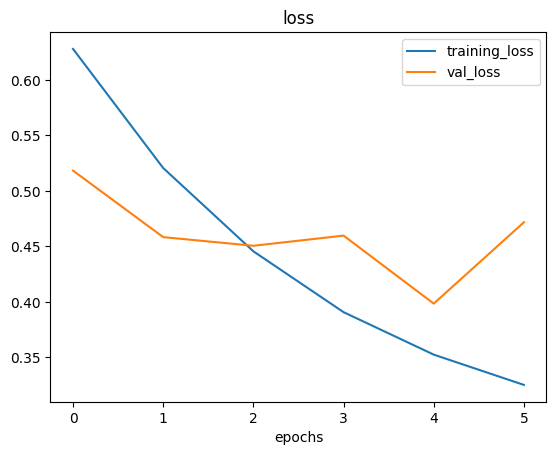

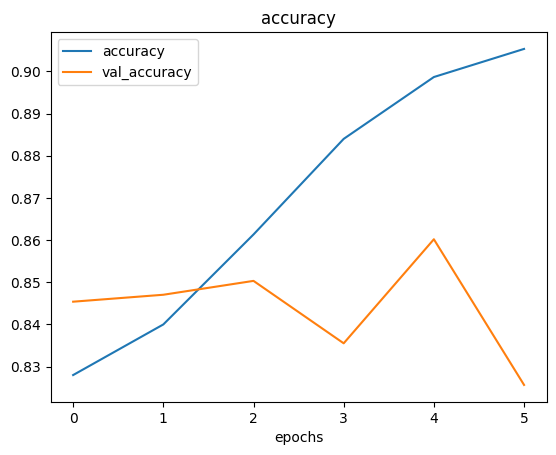

In [24]:
plot_loss(history_3)

In [19]:
#Plot loss curves function is good for models that have only been fit once.
#We want something that can compare before and after fine-tuning

In [25]:
def compare_histories(prior_history, new_history, initial_epochs=5):
  """Compares two TensorFlow History objects"""
  #Get prior metrics
  acc = prior_history.history['accuracy']
  loss = prior_history.history['loss']

  val_acc = prior_history.history['val_accuracy']
  val_loss = prior_history.history['val_loss']

  #Combine
  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']

  total_val_acc = val_acc + new_history.history['val_accuracy']
  total_val_loss = val_loss + new_history.history['val_loss']

  #Make acc plots
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label='Training Accuracy')
  plt.plot(total_val_acc, label='Validation Accuracy')
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), 'k--', label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  #Make loss plots
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_loss, label='Training Loss')
  plt.plot(total_val_loss, label='Validation Loss')
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), 'k--', label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')

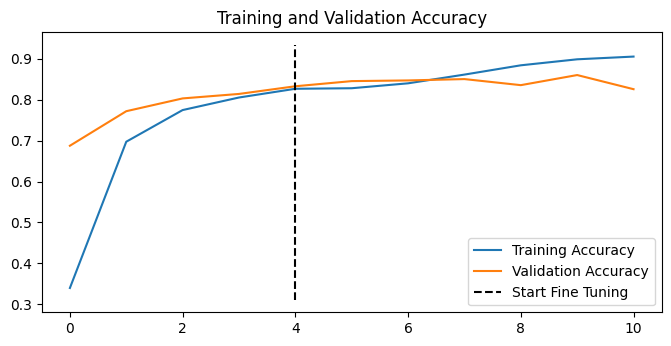

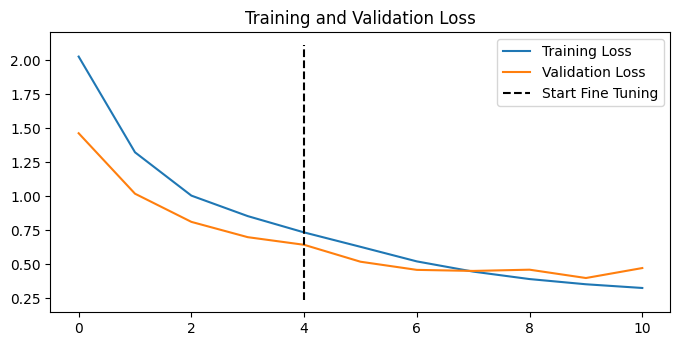

In [26]:
compare_histories(history_2, history_3)

# Fourth model will be trained on 100% of the data

In [27]:
url = 'https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip'
filename = '10_food_classes_all_data.zip'
file = urllib.request.urlretrieve(url, filename)
zip_ref = zipfile.ZipFile(filename)
zip_ref.extractall()
zip_ref.close()

In [28]:
#Set up training and test directories
train_dir_all = '10_food_classes_all_data/train'
test_dir = '10_food_classes_all_data/test'

for dirpath, dirname, filename in os.walk('10_food_classes_all_data'):
  print(f'{len(dirname)} directories and {len(filename)} files in {dirpath}')

2 directories and 0 files in 10_food_classes_all_data
10 directories and 0 files in 10_food_classes_all_data/train
0 directories and 750 files in 10_food_classes_all_data/train/chicken_wings
0 directories and 750 files in 10_food_classes_all_data/train/hamburger
0 directories and 750 files in 10_food_classes_all_data/train/pizza
0 directories and 750 files in 10_food_classes_all_data/train/ice_cream
0 directories and 750 files in 10_food_classes_all_data/train/grilled_salmon
0 directories and 750 files in 10_food_classes_all_data/train/fried_rice
0 directories and 750 files in 10_food_classes_all_data/train/steak
0 directories and 750 files in 10_food_classes_all_data/train/chicken_curry
0 directories and 750 files in 10_food_classes_all_data/train/ramen
0 directories and 750 files in 10_food_classes_all_data/train/sushi
10 directories and 0 files in 10_food_classes_all_data/test
0 directories and 250 files in 10_food_classes_all_data/test/chicken_wings
0 directories and 250 files in 1

In [29]:
from tensorflow.python.ops.variables import local_variables_initializer
train_data_all = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all,
                                                                     label_mode='categorical',
                                                                     image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


We need to revert `model_2` back to its checkpoint weights since we will fine tune from that point and compare

In [34]:
# I ran into a nasty shape error. Instead of simply loading in the weights,
# I'll recreate the model architecture here to ensure compatibility
#model_2.load_weights('ten_percent_model_checkpoints_weights/checkpoint.ckpt')

#Create model 4 with built-in data augmentation

#Create aug layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomRotation(0.2)
], name='data_augmentation')

#Input shape
input_shape = (224, 224, 3)

#Frozen base model (backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#Inputs, outputs, other layers
inputs = tf.keras.layers.Input(shape=input_shape, name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_2D')(x)
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)
model_4 = tf.keras.Model(inputs, outputs)

#Compile
model_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

#Load in checkpointed weights
model_4.load_weights('ten_percent_model_checkpoints_weights/checkpoint.ckpt')

#Make last 10 layers trainable
base_model.trainable = True

for layer in base_model.layers[:-10]:
  layer.trainable = False

#Recompile every time a change is made
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

In [35]:
#Check tunable layers
for layer_number, layer in enumerate(model_4.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [36]:
#Again, let's look specifically at efficientnet
for layer_n, layer in enumerate(model_2.layers[2].layers):
    if layer.trainable:
      print(layer_n, layer.name, layer.trainable) #Wonderful. It looks like rebuilding the model worked

228 block7a_se_squeeze True
229 block7a_se_reshape True
230 block7a_se_reduce True
231 block7a_se_expand True
232 block7a_se_excite True
233 block7a_project_conv True
234 block7a_project_bn True
235 top_conv True
236 top_bn True
237 top_activation True


In [37]:
#Now for training on all the data
fine_tune_epochs = initial_epochs + 5

history_4 = model_4.fit(train_data_all,
                        epochs=fine_tune_epochs,
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        initial_epoch=history_2.epoch[-1], #Again, training starts where weights left off
                        callbacks=[tensorboard(dir_name='transfer_learning',
                                               experiment_name='full_10_classes_finetune_last_10')])

Saving TensorBoard log files to transfer_learning/full_10_classes_finetune_last_10/20230919-025703
Epoch 5/10
235/235 [==============================] - 75s 283ms/step - loss: 0.7122 - accuracy: 0.7872 - val_loss: 0.4125 - val_accuracy: 0.8898
Epoch 6/10
235/235 [==============================] - 61s 256ms/step - loss: 0.5842 - accuracy: 0.8163 - val_loss: 0.3674 - val_accuracy: 0.8914
Epoch 7/10
235/235 [==============================] - 55s 231ms/step - loss: 0.5382 - accuracy: 0.8316 - val_loss: 0.3663 - val_accuracy: 0.8882
Epoch 8/10
235/235 [==============================] - 51s 213ms/step - loss: 0.4979 - accuracy: 0.8437 - val_loss: 0.3422 - val_accuracy: 0.8980
Epoch 9/10
235/235 [==============================] - 48s 203ms/step - loss: 0.4716 - accuracy: 0.8519 - val_loss: 0.3132 - val_accuracy: 0.9030
Epoch 10/10
235/235 [==============================] - 43s 181ms/step - loss: 0.4401 - accuracy: 0.8633 - val_loss: 0.3209 - val_accuracy: 0.8964


In [38]:
results_finetune_all = model_4.evaluate(test_data)
results_finetune_all

79/79 [==============================] - 7s 81ms/step - loss: 0.3116 - accuracy: 0.8952


[0.31159791350364685, 0.8952000141143799]

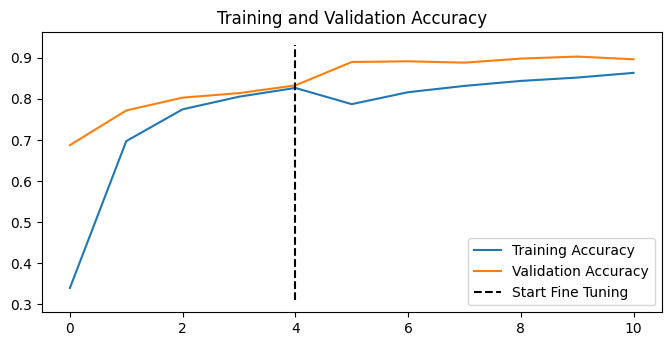

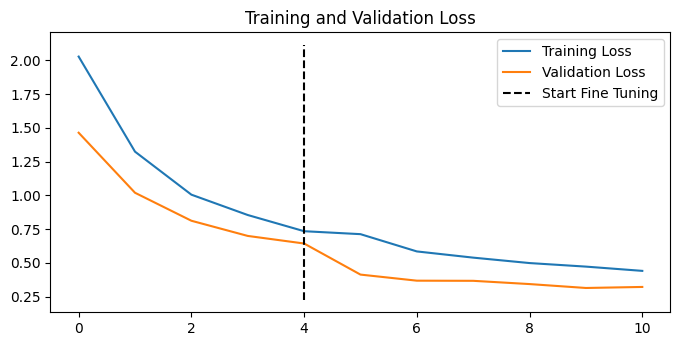

In [39]:
compare_histories(history_2, history_4)

In [42]:
#View our experiment data on Tensorboard (this is public)
!tensorboard dev upload --logdir ./transfer_learning \
--name "Transfer Learning Experiments with 10 Food101 Classes"\
--description "A series of different transfer learning experiments with various amounts of data and data augmentation"\
--one_shot #exits uploader

2023-09-19 03:12:13.683573: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:




New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/S16G

In [ ]:
#Experiment here: https://tensorboard.dev/experiment/S16GhDkqQAOW0ykLLOsyxA/
#can delete if not wanted